To reproduce this experiment, the following commands need to be run:

```shell
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=afl fed="mnist_all_$i" task="mnist"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=afl fed="mnist_all_$i" task="mnist_no_scheduler"; done
for i in {1..5}; do poetry run python -m project.main --config-name=mnist use_wandb=true strategy=afl fed="mnist_$i" task="mnist"; done
```

The results of the runs should be renamed on wandb in this order:
1. f"afl_{i}_lr_schedule_all" - e.g. afl_1_lr_schedule_all
2. f"afl_{i}_noschedule_all"
3. f"afl_{i}_compare"

In [ ]:
# Setup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import wandb
from pathlib import Path
from plotting.wandb_utils import get_filtered_runs

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = [
    "Times New Roman",
] + plt.rcParams["font.serif"]
sns.set_style("whitegrid")
CB_color_cycle = [
    "#377EB8",
    "#FF7F00",
    "#4DAF4A",
    "#F781BF",
    "#A65628",
    "#984EA3",
    "#999999",
    "#E41A1C",
    "#DEDE00",
]

We download our data from Weights and Biases

In [109]:
api = wandb.Api()
entity, project = "kornelszabo", "template"

artifacts = get_filtered_runs(
    lambda run: "afl" in run.name and "all" in run.name,
    api=api,
    entity=entity,
    project=project,
)

We format our dataset and plot the train/test accuracies.

In [110]:
def get_name(cell):
    parts = cell.split("_")
    return f"{parts[0]}_{'no_scheduler' if len(parts) == 4 else ''}"

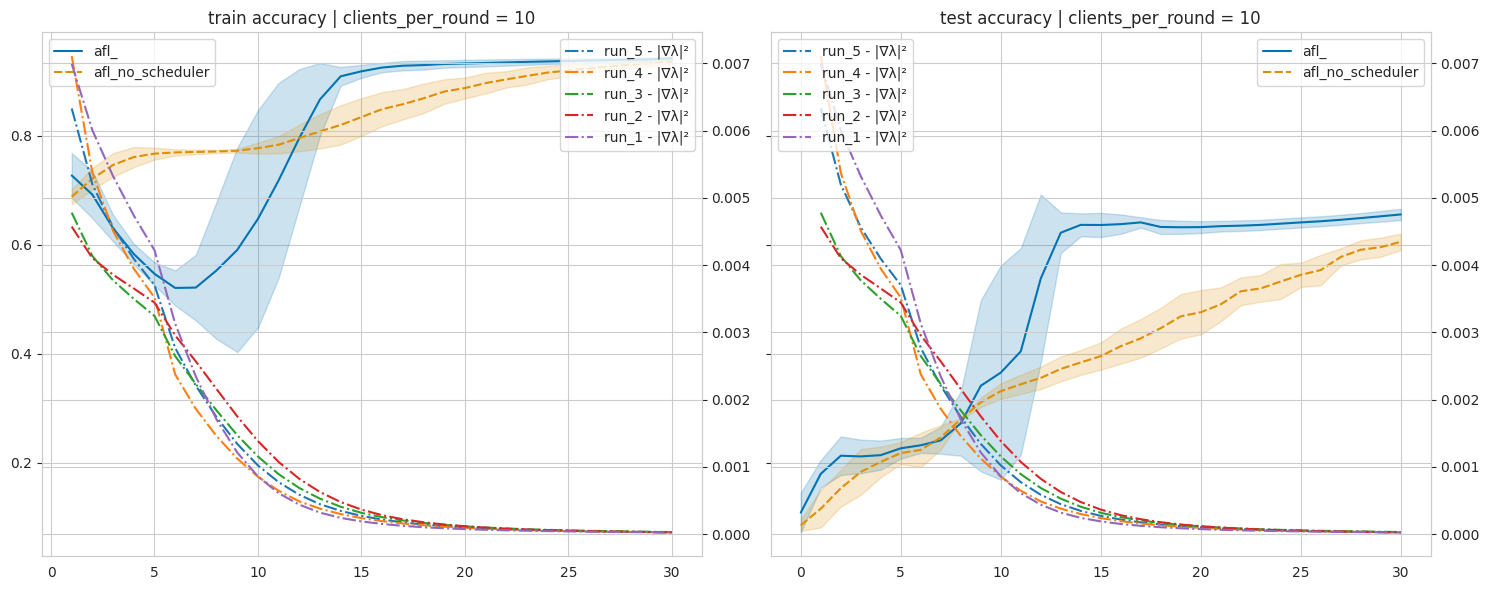

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6), sharey=True)


def plot_artifacts(artifacts, ax):
    train = pd.DataFrame(
        np.array([v.train_accuracy.values[:31] for v in artifacts.values()]).T,
        columns=[get_name(key) for key in artifacts],
    )

    test = pd.DataFrame(
        np.array([v.test_accuracy.values[:31] for v in artifacts.values()]).T,
        columns=[get_name(key) for key in artifacts],
    )

    sns.lineplot(train, errorbar="sd", palette="colorblind", ax=ax[0]).set_title(
        "train accuracy | clients_per_round = 10"
    )
    sns.lineplot(test, errorbar="sd", palette="colorblind", ax=ax[1]).set_title(
        "test accuracy | clients_per_round = 10"
    )

    diffs = None
    for i in range(10):
        dfx = pd.DataFrame(
            np.array([
                v[f"lambdas_{i}"].values[:31]
                for k, v in artifacts.items()
                if "no" not in get_name(k)
            ]).T,
            columns=[
                f"run_{k.split('_')[1]} - |∇λ|²"
                for k in artifacts
                if "no" not in get_name(k)
            ],
        ).fillna(0.1)

        if diffs is None:
            diffs = dfx * 0

        diffs += dfx.diff(axis=0).pipe(np.square).rolling(5, min_periods=1).mean()

    diffs.plot(ax=ax[0].twinx(), linestyle="-.").legend(loc="upper right")
    diffs.plot(ax=ax[1].twinx(), linestyle="-.").legend(loc="upper left")


plot_artifacts(artifacts, ax)

plt.tight_layout()


plt.savefig("./plots/exp_1.png", bbox_inches="tight")

We compute the Pearson-correlation for the first 3 pairs of runs
and report the highest p-value and lowest correlation.

In [112]:
values = [[] for _ in range(51)]
correlations = []
p_values = []
columns = []
for file in ["train_accuracy", "test_accuracy"]:
    df = pd.concat(
        [
            artifacts[f"afl_{j}_lr_schedule_all"][file].rename(str(j)).to_frame()
            for j in range(1, 4)
        ],
        axis=1,
    ).dropna()
    cols = [str(j) for j in range(1, 4)]
    columns.extend([file for _ in range(3)])
    for i, row in enumerate(df[cols].dropna().values):
        values[i].extend(row)

    corr_1 = scipy.stats.pearsonr(df[cols[0]], df[cols[1]])
    corr_2 = scipy.stats.pearsonr(df[cols[0]], df[cols[2]])
    corr_3 = scipy.stats.pearsonr(df[cols[1]], df[cols[2]])

    p_values.append([x.pvalue for x in [corr_1, corr_2, corr_3]])
    correlations.extend([x.statistic for x in [corr_1, corr_2, corr_3]])

In [113]:
pd.DataFrame(
    p_values,
    columns=["runs 1, 2", "runs 1, 3", "runs 2, 3"],
    index=["train_accuracy", "test_accuracy"],
)

,"runs 1, 2","runs 1, 3","runs 2, 3"
train_accuracy,1.569586e-10,2.636218e-14,4.778512e-34
test_accuracy,8.236244e-16,5.861187e-18,7.922727e-36


In [114]:
pd.Series(correlations).nsmallest(5)

0    0.759834
1    0.839411
3    0.858360
4    0.885794
2    0.977387
dtype: float64

We download the experiments where we only sample half of the clients and plot the test accuracy trajectories (colored based on whether or not they converge)

In [116]:
arts = get_filtered_runs(
    lambda run: "afl" in run.name and "compare" in run.name,
    api=api,
    entity=entity,
    project=project,
)

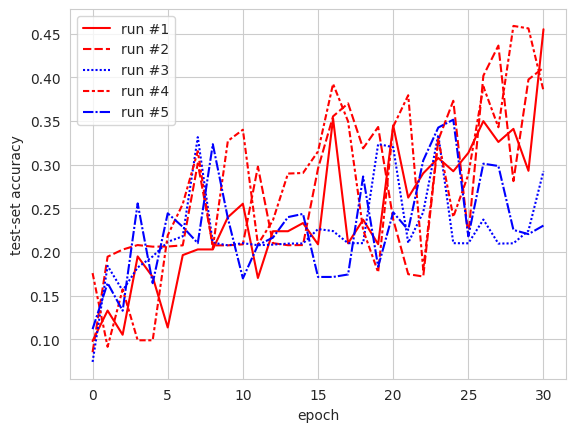

In [117]:
x = sns.lineplot(
    pd.concat(
        [
            arts[f"afl_{i}_compare"].test_accuracy.rename(f"run #{i}")
            for i in range(1, 6)
        ],
        axis=1,
    ),
    errorbar=None,
    palette=sns.color_palette(palette=["red", "red", "blue", "red", "blue"]),
).set(xlabel="epoch", ylabel="test-set accuracy")

plt.savefig("plots/exp_1_1.png")